In [21]:
# necessary imports
import numpy as np

from squlearn.util import Executor
from squlearn.feature_map import ChebPQC
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.ml import QGPR
from squlearn.kernel.optimization import KernelOptimizer
from squlearn.kernel.optimization import NLL

In [22]:
# Generate training data.
def func(x):
    return np.sin(3 * x) * x * x


noise_std = 0.1
X_test = np.linspace(-1, 1, 100)
Y_test = func(X_test)
X_train = np.linspace(-1, 1, 15)
Y_train = func(X_train) + np.random.normal(scale=noise_std, size=len(X_train))

In [23]:
# set up quantum kernel and qgpr
num_qubits = 4
fmap = ChebPQC(num_qubits, num_features=1, num_layers=2)
np.random.seed(0)
param = np.random.rand(fmap.num_parameters)
q_kernel = FidelityKernel(feature_map=fmap, executor=Executor("statevector_simulator"))

In [24]:
from squlearn.optimizers import Adam

adam = Adam(options={"maxiter": 20, "lr": 0.1})
nll_loss = NLL(quantum_kernel=q_kernel, sigma=noise_std**2)
optimizer = KernelOptimizer(loss=nll_loss, optimizer=adam, initial_parameters=param)

In [25]:
opt_result = optimizer.run_optimization(x=X_train.reshape(-1, 1), y=Y_train)

In [26]:
# perform qgpr
optimal_parameters = opt_result.x
q_kernel.assign_parameters(optimal_parameters)
qgpr_ansatz = QGPR(quantum_kernel=q_kernel, sigma=noise_std**2)
qgpr_ansatz.fit(X_train=X_train.reshape(-1, 1), y_train=Y_train)
qgpr_mean, qgpr_std = qgpr_ansatz.predict(X_test=X_test.reshape(-1, 1))

Regularizing full Gram matrix
Reconstruction error 2.7984281558701696e-12


Text(0, 0.5, '$f(x)$')

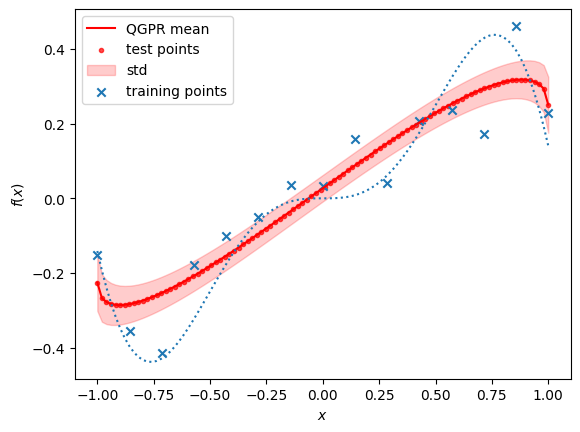

In [27]:
from matplotlib import pyplot as plt

# plot result
plt.plot(X_test.reshape(-1, 1), qgpr_mean, color="red", label="QGPR mean")
plt.scatter(
    X_test.reshape(-1, 1), qgpr_mean, marker=".", label="test points", color="red", alpha=0.7
)
plt.fill_between(
    X_test.reshape(-1),
    qgpr_mean.reshape(-1) - qgpr_std,
    qgpr_mean.reshape(-1) + qgpr_std,
    color="red",
    label="std",
    alpha=0.2,
)
plt.scatter(X_train, Y_train, marker="x", label="training points")
plt.plot(X_test, Y_test, linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")